In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.linear_model import Perceptron
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score , roc_curve, auc

from sklearn.naive_bayes import GaussianNB

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/weather.csv"
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Usuwanie niepotrzebnych kolumn
df.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
                 'WindSpeed9am', 'WindSpeed3pm', 'Cloud9am', 'Cloud3pm', 'RISK_MM', 'RainToday'], inplace=True)

# Interpolacja i mapowanie
df['WindGustSpeed'].interpolate(method='linear', inplace=True)
df['Sunshine'].interpolate(method='linear', inplace=True)
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Uzupełnianie brakujących wartości
df_filled = df.fillna(df.mean())

# Podział na cechy i etykiety
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Uzupełnienie brakujących wartości średnią
df_filled = df.fillna(df.mean())
X = df_filled.drop('RainTomorrow', axis=1)
y = df_filled['RainTomorrow']

# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model SVM

Accuracy using SVM: 0.8783783783783784
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        58
           1       0.82      0.56      0.67        16

    accuracy                           0.88        74
   macro avg       0.85      0.76      0.80        74
weighted avg       0.87      0.88      0.87        74



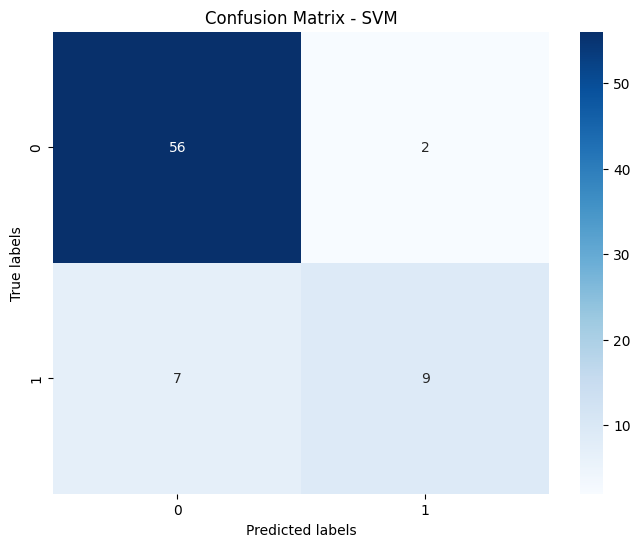

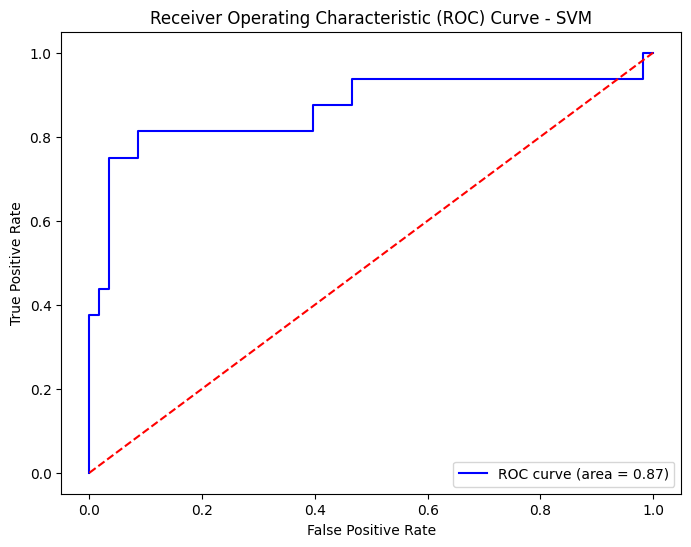

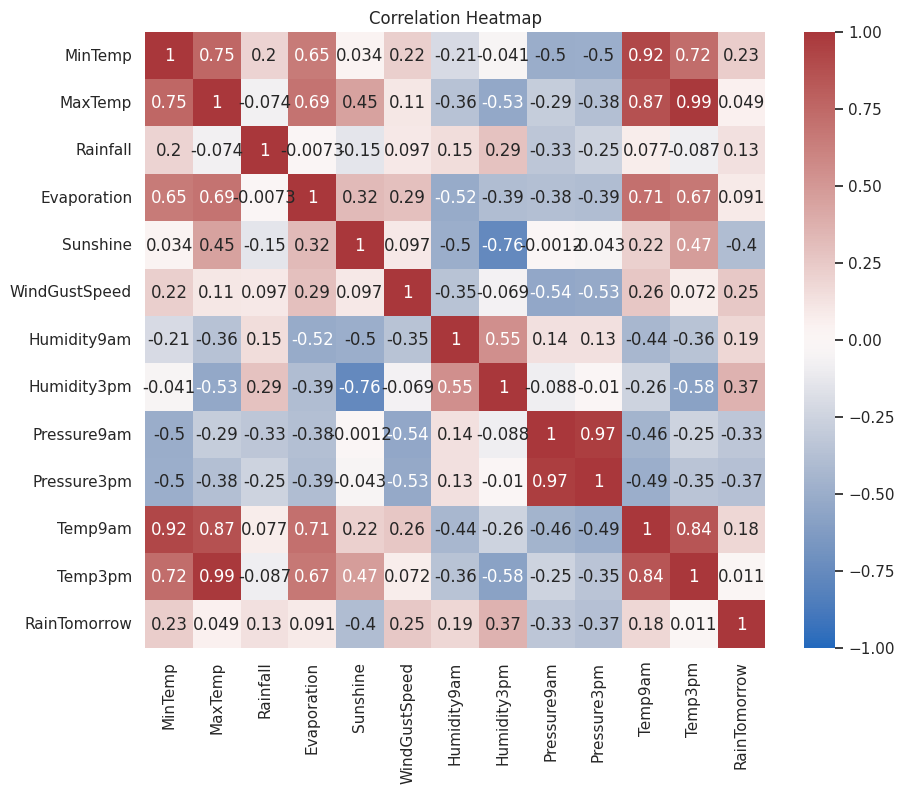

In [6]:
# Inicjacja i trenowanie modelu SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Przewidywanie dla zbioru testowego
y_pred = svm_model.predict(X_test_scaled)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using SVM: {accuracy}")
print(classification_report(y_test, y_pred))

# Macierz pomyłek i wizualizacja
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM')
plt.show()

# Obliczenie krzywej ROC
y_pred_prob = svm_model.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Wykres krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()

# Wizualizacja macierzy korelacji
sns.set()
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Model drzewa decyzyjnego

Accuracy using Decision Tree: 0.7162162162162162
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        58
           1       0.31      0.25      0.28        16

    accuracy                           0.72        74
   macro avg       0.56      0.55      0.55        74
weighted avg       0.70      0.72      0.71        74



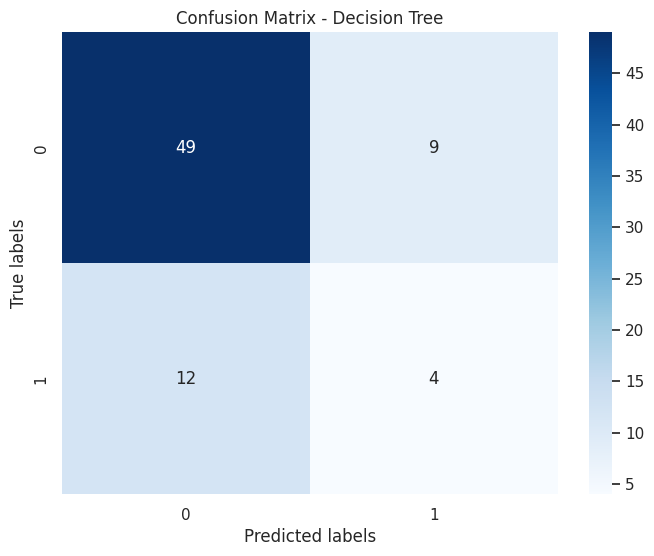

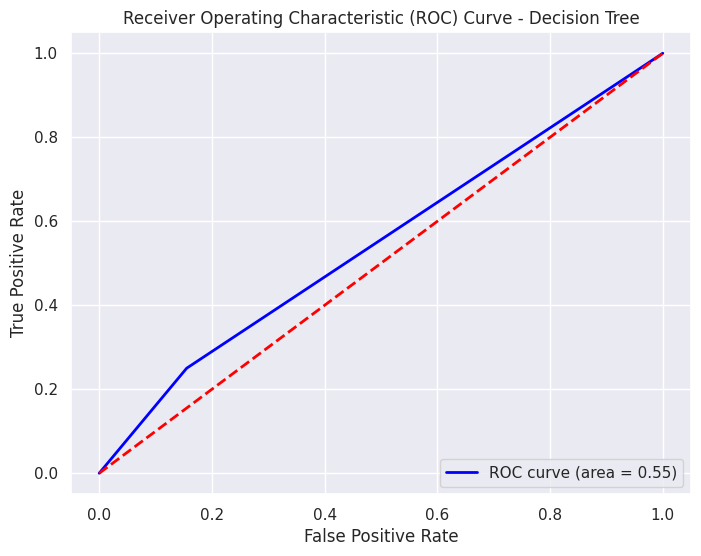

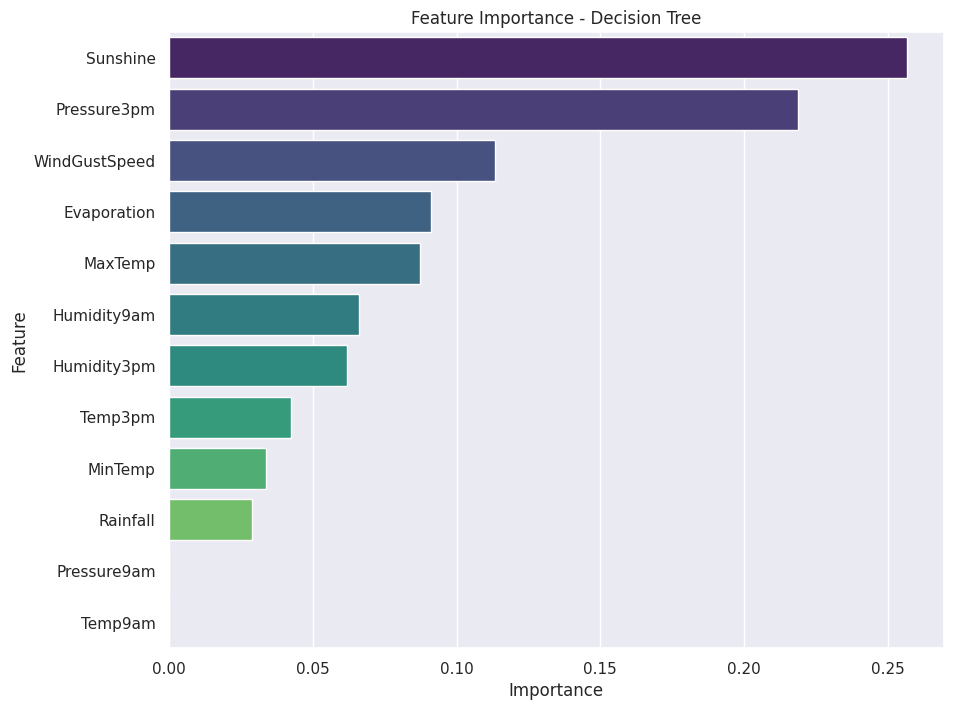

In [7]:
# Inicjacja i trenowanie modelu drzewa decyzyjnego
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Ocena i wizualizacja drzewa decyzyjnego
print(f"Accuracy using Decision Tree: {accuracy_tree}")
print(classification_report(y_test, y_pred_tree))

# Wizualizacja macierzy pomyłek dla drzewa decyzyjnego
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# Uzyskanie prawdopodobieństw przynależności do klasy pozytywnej (1)
y_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

# Obliczenie krzywej ROC dla drzewa decyzyjnego
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_prob_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Wyświetlenie krzywej ROC dla drzewa decyzyjnego
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Uzyskanie znaczenia cech z drzewa decyzyjnego
feature_importances = decision_tree.feature_importances_

# Tworzenie ramki danych z cechami i ich znaczeniem
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wizualizacja znaczenia cech
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Model Perceptron

Accuracy using Perceptron: 0.8108108108108109
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        58
           1       0.58      0.44      0.50        16

    accuracy                           0.81        74
   macro avg       0.72      0.68      0.69        74
weighted avg       0.80      0.81      0.80        74



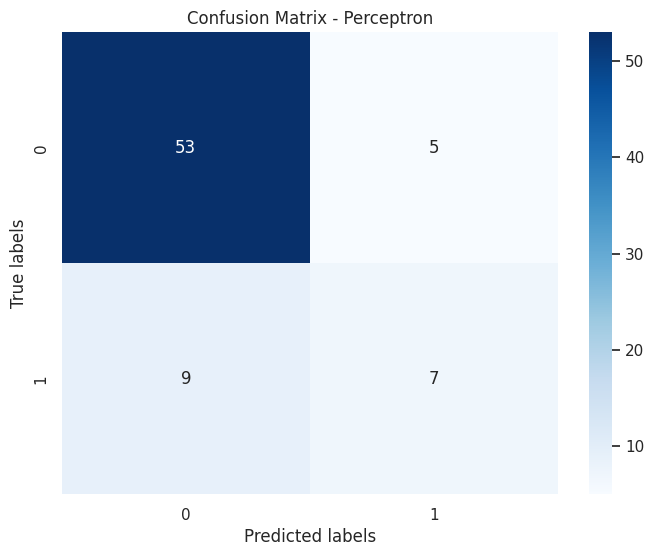

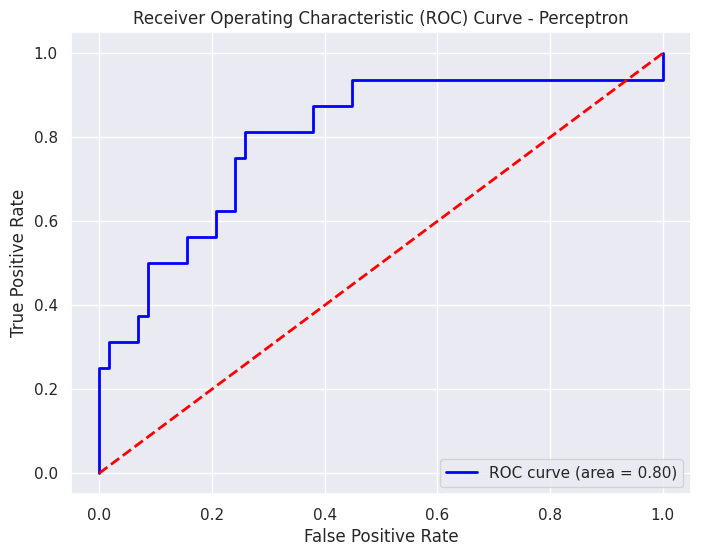

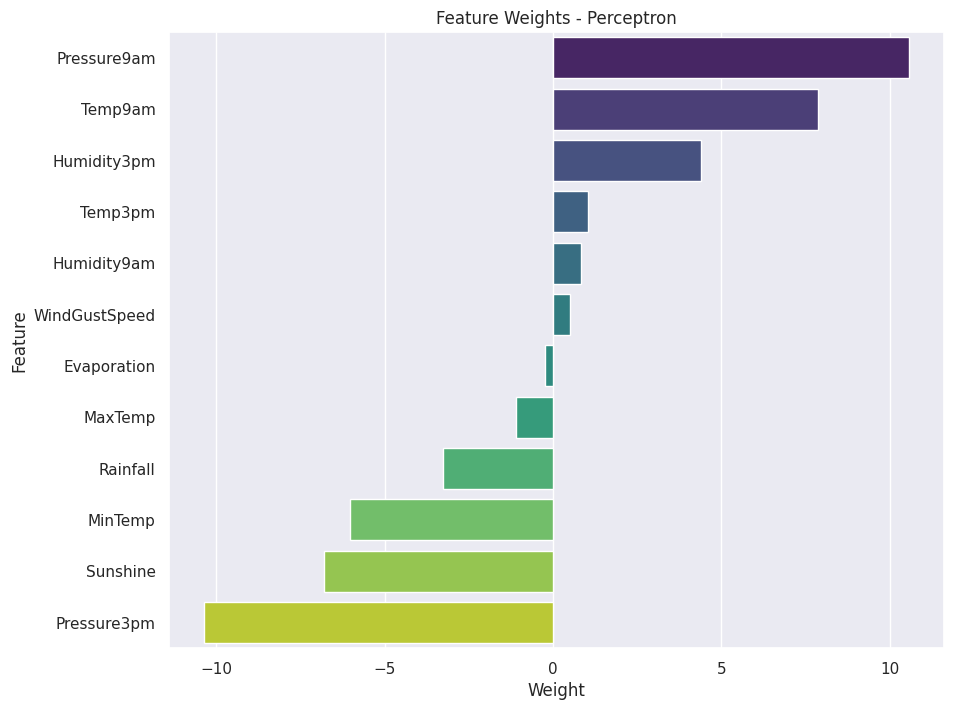

In [8]:
# Inicjacja i trenowanie modelu Perceptron
perceptron = Perceptron()
perceptron.fit(X_train_scaled, y_train)
y_pred_perceptron = perceptron.predict(X_test_scaled)

# Ocena i wizualizacja perceptronu
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)
print(f"Accuracy using Perceptron: {accuracy_perceptron}")
print(classification_report(y_test, y_pred_perceptron))

# Wizualizacja macierzy pomyłek dla perceptronu
conf_matrix_perceptron = confusion_matrix(y_test, y_pred_perceptron)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_perceptron, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Perceptron')
plt.show()

# Obliczenie krzywej ROC dla perceptronu
y_scores_perceptron = perceptron.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_perceptron)
roc_auc = auc(fpr, tpr)

# Wyświetlenie krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Perceptron')
plt.legend(loc="lower right")
plt.show()

# Uzyskanie wag dla cech
weights = perceptron.coef_[0]

# Tworzenie ramki danych z cechami i ich wagami
feature_weights_df = pd.DataFrame({'Feature': X.columns, 'Weight': weights})
feature_weights_df = feature_weights_df.sort_values(by='Weight', ascending=False)

# Wizualizacja wag cech
plt.figure(figsize=(10, 8))
sns.barplot(x='Weight', y='Feature', data=feature_weights_df, palette='viridis')
plt.title('Feature Weights - Perceptron')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()

Model KNN

KNN - Accuracy: 0.8108108108108109
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        58
           1       0.62      0.31      0.42        16

    accuracy                           0.81        74
   macro avg       0.73      0.63      0.65        74
weighted avg       0.79      0.81      0.79        74



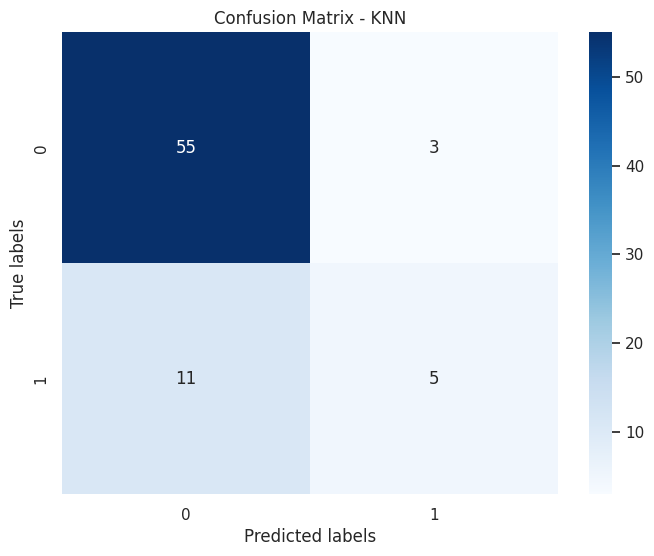

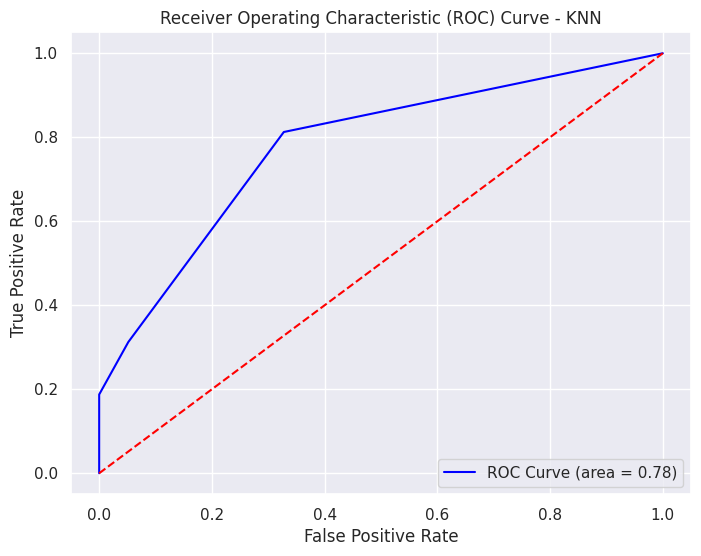

In [9]:
# Inicjacja i trenowanie modelu KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Przewidywanie dla zbioru testowego
y_pred = knn.predict(X_test_scaled)

# Ewaluacja dla KNN
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"KNN - Accuracy: {accuracy_knn}")
print(classification_report(y_test, y_pred))

# Macierz pomyłek
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - KNN')
plt.show()

# Pobranie prawdopodobieństwa klasy 1
y_pred_prob = knn.predict_proba(X_test_scaled)[:, 1]

# Obliczenie krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Wykres krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()

Model Liniowej Regresji

Linear Regression - Mean Squared Error (MSE): 0.09759518777196845
Linear Regression - R-squared (R2): 0.42410425836282417
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        58
           1       0.83      0.62      0.71        16

    accuracy                           0.89        74
   macro avg       0.87      0.80      0.82        74
weighted avg       0.89      0.89      0.89        74



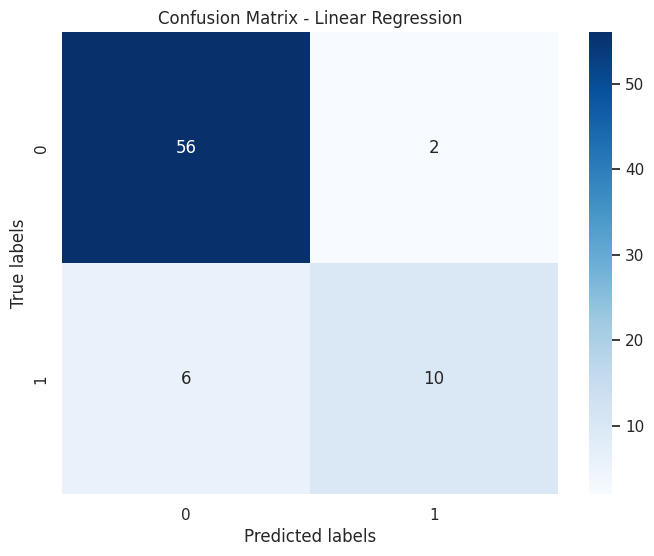

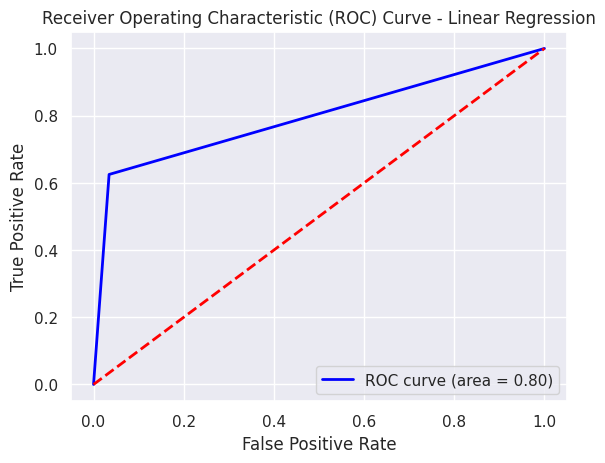

In [10]:
# Trenowanie modelu regresji liniowej
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predykcje dla zbioru testowego
y_pred_lr = model_lr.predict(X_test)

# Konwersja predykcji na format binarny (na podstawie progu 0.5)
y_pred_binary = [1 if val > 0.5 else 0 for val in y_pred_lr]

# Ewaluacja dla regresji liniowej
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - Mean Squared Error (MSE): {mse_lr}")
print(f"Linear Regression - R-squared (R2): {r2_lr}")

# Raport klasyfikacji
print(classification_report(y_test, y_pred_binary))

# Macierz pomyłek dla regresji liniowej
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Linear Regression')
plt.show()

# Krzywa ROC dla regresji liniowej
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Linear Regression')
plt.legend(loc="lower right")
plt.show()

Model Naive Bayesa

Accuracy using Gaussian Naive Bayes: 0.8783783783783784
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        58
           1       0.73      0.69      0.71        16

    accuracy                           0.88        74
   macro avg       0.82      0.81      0.82        74
weighted avg       0.88      0.88      0.88        74



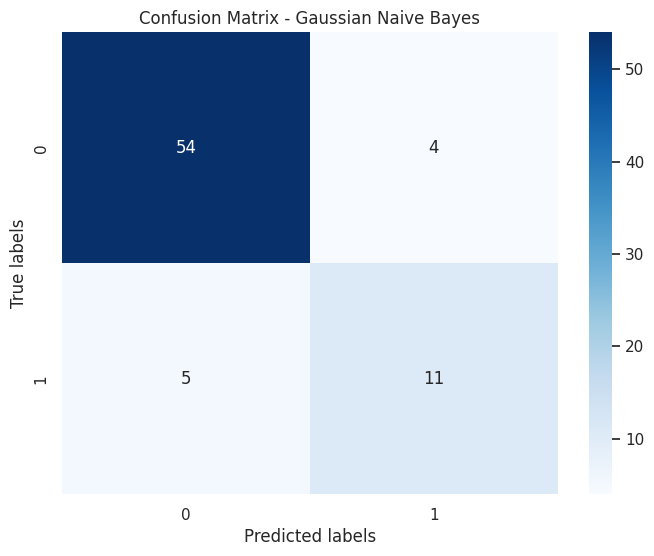

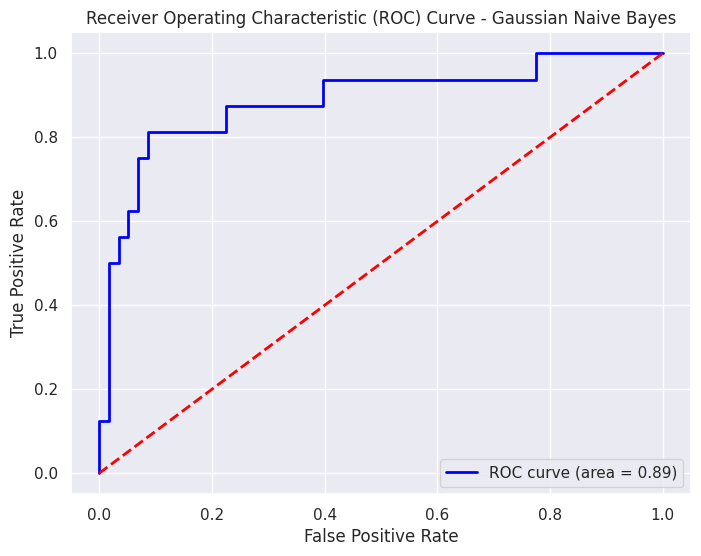

In [11]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_scaled, y_train)
y_pred = naive_bayes.predict(X_test_scaled)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using Gaussian Naive Bayes: {accuracy}")

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

# Macierz pomyłek
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

# Pobranie prawdopodobieństwa klasy 1
y_pred_prob = naive_bayes.predict_proba(X_test_scaled)[:, 1]

# Obliczenie krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Wykres krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

Podsumowanie: z wybranych przeze mnie modeli nauczania maszynowego największą dokładność uzyskały modele: SVM, liniowej regresji oraz Naive Bayesa, z kolei najgorszą dokładność uzyskał model drzewa decyzyjnego.